***
### Import of required libraries
***

In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.models import load_model
from geopy.distance import distance

from traffic.core import Traffic
from tqdm.auto import tqdm

2024-06-20 13:38:30.418267: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 13:38:30.609911: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 13:38:30.609954: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 13:38:30.610573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-20 13:38:30.684853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 13:38:30.686487: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

***
### Import of data, model and scalers
***

##### Trajectory data

In [13]:
t = Traffic.from_file(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/t_test.parquet"
)

##### Model

In [3]:
def rmse_lat():
    return None


def rmse_lon():
    return None


def rmse_alt():
    return None


model = load_model(
    f"/home/krum/git/MT_krum_code/models/snowy-gorge-126.keras",
    custom_objects={
        "rmse_lat": rmse_lat,
        "rmse_lon": rmse_lon,
        "rmse_alt": rmse_alt,
        "weighted_mse": tf.keras.losses.MeanSquaredError(),
    },
)

##### Scalers

In [4]:
# scaler_in
with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_in.pkl",
    "rb",
) as file:
    scaler_in = pickle.load(file)

# scaler_out
with open(
    "/mnt/beegfs/store/krum/MT/encoded_scaled_split/scaler_out.pkl",
    "rb",
) as file:
    scaler_out = pickle.load(file)

***
### Take-off distance determination
***

In [14]:
# To be removed
t = t.sample(1000)

#### For each flight, determine predicted and actual Take-off distance

In [15]:
# Function to calculate distance between two points contained in rows
def calculate_distance(row1, row2):
    coords_1 = (row1["latitude"], row1["longitude"])
    coords_2 = (row2["latitude"], row2["longitude"])
    return distance(coords_1, coords_2).meters


# Lists to store actual and predicted take-off distances
actual_to_dist_m = []
pred_to_dist_m = []

# Iterate over flights
for flight in tqdm(t):
    try:
        # Determine actual take-off distance and add to list--------------------
        flightdata = flight.cumulative_distance().data
        flightdata["cumdist_m"] = flightdata["cumdist"] * 1852
        runalt_m = ((flightdata[0:10].altitude) / 3.281).mean()
        flightdata["agl_m"] = (flightdata.altitude / 3.281) - runalt_m
        flightdata["status"] = np.where(flightdata["agl_m"] >= 50, "air", "ground")
        to_dist_m = round(
            flightdata[flightdata["status"] == "air"]["cumdist_m"].iloc[0]
        )
        actual_to_dist_m.append(to_dist_m)

        # Determine predicted take-off distance and add to list-----------------
        # Generate prediction for first input and unscale
        f_in_var_unscaled = flight.data[
            [
                "latitude",
                "longitude",
                "altitude",
            ]
        ].iloc[0:10]

        input_var = (
            flight.data[
                [
                    "latitude_scaled",
                    "longitude_scaled",
                    "altitude_scaled",
                    "wind_x_2min_avg_scaled",
                    "wind_y_2min_avg_scaled",
                    "temperature_gnd_scaled",
                    "humidity_gnd_scaled",
                    "pressure_gnd_scaled",
                ]
            ]
            .iloc[0:10]
            .to_numpy()
            .reshape(1, 10, 8)
        )

        input_con = (
            flight.data[
                [
                    "toff_weight_kg_scaled",
                    "typecode_A20N",
                    "typecode_A21N",
                    "typecode_A319",
                    "typecode_A320",
                    "typecode_A321",
                    "typecode_A333",
                    "typecode_A343",
                    "typecode_B77W",
                    "typecode_BCS1",
                    "typecode_BCS3",
                    "typecode_CRJ9",
                    "typecode_DH8D",
                    "typecode_E190",
                    "typecode_E195",
                    "typecode_E290",
                    "typecode_E295",
                    "typecode_F100",
                    "typecode_SB20",
                    "SID_DEGES",
                    "SID_GERSA",
                    "SID_VEBIT",
                    "SID_ZUE",
                    "hour_sin",
                    "hour_cos",
                    "weekday_sin",
                    "weekday_cos",
                    "month_sin",
                    "month_cos",
                ]
            ]
            .iloc[10]
            .to_numpy()
            .reshape(1, 1, 29)
        )
        output = model.predict((input_var, input_con), verbose=0)
        output_unscaled = scaler_out.inverse_transform(output.reshape(-1, 3)).reshape(
            37, 3
        )[1:, :]

        # Create dataframe containing input and prediction and resample to 1s
        df_in = f_in_var_unscaled
        df_out = pd.DataFrame(
            output_unscaled, columns=["latitude", "longitude", "altitude"]
        )
        df_out["Time"] = [i * 5 for i in range(len(df_out))]
        df_out.set_index("Time", inplace=True)
        time_index = pd.RangeIndex(start=0, stop=df_out.index[-1] + 1, step=1)
        df_out = df_out.reindex(time_index)
        df_out = df_out.interpolate(method="linear")
        df_out.reset_index(inplace=True)
        df_out.rename(columns={"index": "Time"}, inplace=True)
        df = pd.concat([df_in, df_out]).reset_index(drop=True)

        # Calculate AGL altitude and add to new column
        df["agl_m"] = (df.altitude / 3.281) - runalt_m

        # Calculate travelled distance and add to new column
        dist_diff = df.apply(
            lambda row: (
                calculate_distance(df.loc[row.name - 1], row) if row.name > 0 else 0
            ),
            axis=1,
        )
        df["cumdist"] = dist_diff.cumsum()

        # Determine distance and add to list
        to_dist_pred = round(df[df["agl_m"] >= 50]["cumdist"].iloc[0])
        pred_to_dist_m.append(to_dist_pred)
    except:
        print("No detectable take-off")

100%|██████████| 1000/1000 [01:42<00:00,  9.80it/s]


#### Combine into one dataframe and compute

In [16]:
# Convert lists to Pandas Series
pred_to_dist_m_series = pd.Series(pred_to_dist_m, name="Predicted")
actual_to_dist_m_series = pd.Series(actual_to_dist_m, name="Actual")

# Combine series into DataFrame
df_to = pd.concat([pred_to_dist_m_series, actual_to_dist_m_series], axis=1)

# Calculate the error between predicted and actual take-off distances
df_to['Error'] = df_to["Predicted"] - df_to["Actual"]

***
### Visualisation
***

#### Histograms of predicted and actual distances

In [17]:
# Generate histogram
fig = go.Figure()
fig.add_trace(go.Histogram(x=df_to["Predicted"], name="Predicted", xbins=dict(size=50)))
fig.add_trace(go.Histogram(x=df_to["Actual"], name="Actual", xbins=dict(size=50)))

# Adding a vertical line at x=2500 for the end of the runway
fig.add_shape(
    dict(
        type="line",
        x0=2500,
        y0=0,
        x1=2500,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(
            color="black",
            width=2,
            dash="dashdot",
        ),
    ),
    name="End of runway",
    showlegend=True,
)

# Update Figure layout
fig.update_layout(
    autosize=True,
    height=450,
    barmode="overlay",
    title="Take-off distance histogram",
    margin=dict(l=20, r=20, t=40, b=20),
)
fig.update_traces(opacity=0.4)

# Show plot
fig.show()

#### Boxplot of take-off distance errors

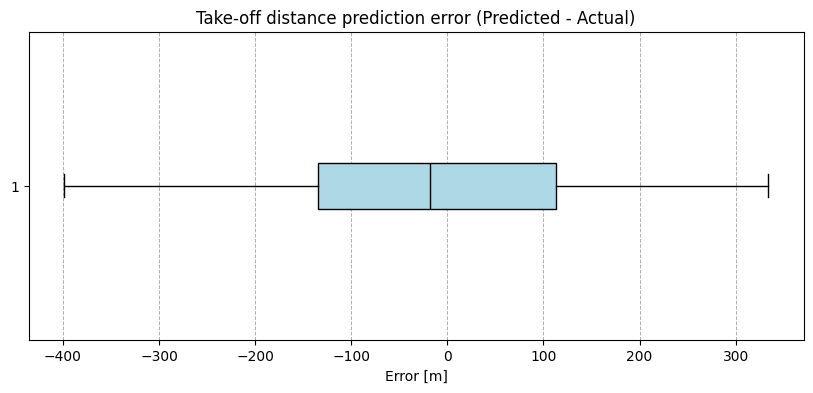

In [10]:
# Generate a boxplot of the error series
plt.figure(figsize=(10, 4))
plt.boxplot(
    df_to["Error"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
    medianprops=dict(color="black"),
    showfliers=False,
)

# Update plot layout
plt.title("Take-off distance prediction error (Predicted - Actual)")
plt.xlabel("Error [m]")
plt.grid(axis='x', linestyle='--', linewidth=0.7)

# Display the plot
plt.show()